<a href="https://colab.research.google.com/github/gpfvm/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_13%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 13강 반정형 데이터 분석 : 게시판 글 데이터 활용

### 목표

방송통신대학교 학생 게시판의 글 제목을 수집하고 분석하여, 반정형 데이터의 수집부터 텍스트 분석까지 전체 과정을 실습

### 분석 프로세스 개요

1. 데이터 수집
  - selenium을 활용한 웹 페이지 접근
  - lxml을 이용한 HTML 파싱
  - 게시글 제목 추출

2. 텍스트 데이터 전처리
  - 정규식을 활용한 텍스트 정제
  - 형태소 분석을 통한 명사 추출

3. 키워드 분석
  - 단어 빈도 분석
  - 워드 클라우드 생성
  - 주요 키워드 추출

4. 텍스트 분류 및 시각화
  - LLM을 활용한 텍스트 분류
  - 분류 결과 시각화
  - 인사이트 도출


# 주의 : 런타임 GPU 로 설정 필요

In [1]:
# LLM 처리를 위한 VLLM 설치 (오래걸리는 작업이므로 미리 실행!)
!pip install vllm
# 필요 시 세션 재시작

INFO: pip is looking at multiple versions of model-hosting-container-standards to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.3/370.3 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.0/355.0 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 7s (1,410 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and dire

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 13-1 웹 스크래핑 라이브러리 설치

In [2]:
!pip install google-colab-selenium lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.0/512.0 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.5 MB/s eta 0:00:00


## 13-2 웹 스크래핑 함수 정의 및 실행

In [3]:
import google_colab_selenium as gs
from lxml import html

## URL로부터 페이지 내용 가져오기
def get_page(driver, url):
    # url 페이지로 이동
    driver.get(url)
    # 해당 페이지의 html을 page_content로 저장
    page_content = driver.page_source
    # page_content를 lxml의 html 객체로 변환하고 tree로 저장
    tree = html.fromstring(page_content)
    return tree

## HTML 트리에서 제목 추출
def extract_titles(tree):
    ## td-subject를 클래스로 가지는 td 태그 > a태그 > strong > text() 을 xpath로 구하고 titles로 저장
    titles = tree.xpath('//td[@class="td-subject"]/a/strong/text()')
    return titles

## 제목 목록 출력
def print_titles(titles):
    for title in titles:
        print(title)

## Chrome 드라이버 초기화
driver = gs.Chrome()

## 컴퓨터과학과 게시판 첫번째 페이지 제목 데이터 수집
board_name = '컴퓨터과학과'
board_url = 'https://cs.knou.ac.kr/cs1/4794/subview.do'
tree = get_page(driver, board_url)
titles = extract_titles(tree)
print_titles(titles)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🏝️ 역대 대통령 휴양지, 환상의 섬 '저도' & 거제도 1박 2일 특
[그로스로그] 그로스톡 (개발 세미나)에 초대합니다!
[TIP] 2025학년도 2학기 기말시험 신청방법
★신편입생 필독사항 🍀학사공지 전용 단톡방 🍀크로바 네이버 카페
방송대 합창단 24주년 18회 정기 연주회 학우 여러분을 초대합니다.
2025년 방송대 합창단 신입단원 모집  합니다.
안녕하세요...수업방식 관련 질문 한 가지 드립니다..
★신편입생 필독사항  컴퓨터과학과 선후배 친구들, 여기 다 모였어요! 💻
디지털 성범죄 예방교육 홍보
컴퓨터 과학이 무신론과 학생회 정치에서 문을 닫게 됩니다. 


## 13-3 다중 페이지 데이터 수집 및 데이터프레임 생성

In [4]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd

## 다음 페이지로 이동하고 tree 정보 반환
def move_to_next_page(driver):
    # _listNext 클래스를 기준으로 엘리먼트 선택
    next_page_link = driver.find_element(By.CLASS_NAME, "_listNext")
    if next_page_link and next_page_link.is_enabled():
        # 다음 페이지 버튼 클릭
        next_page_link.click()
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "board-table"))
        )
        page_content = driver.page_source
        tree = html.fromstring(page_content)
        return tree
    else:
        return None

## 여러 페이지에서 게시물 제목 가져오기
def get_board_titles(url, pages, verbose=False):
    driver = gs.Chrome()
    board_titles = []
    for page in pages:
        if verbose:
          print(f"=== 페이지 {page} 처리중입니다. ===")
        if page == 1:
            # 13-2 에서 작성한 get_page 함수를 이용하여 현재 페이지 tree 구하기
            tree = get_page(driver,url)
        else:
            # 다음 페이지로 이동하고 해당 페이지 tree 구하기
            tree = move_to_next_page(driver)
        if tree is not None:
            titles = extract_titles(tree)
            board_titles.extend(titles)
            if verbose:
              print_titles(titles)
    driver.quit()  # Chrome 드라이버 종료
    return board_titles

## 컴퓨터과학과 게시판 1 페이지 ~ 10 페이지의 제목 데이터 수집
board_name = '컴퓨터과학과'
board_url = 'https://cs.knou.ac.kr/cs1/4794/subview.do'
board_titles = get_board_titles(url=board_url, pages=range(1,11), verbose=True)
## 컴퓨터과학과 제목 데이터프레임 생성
cs_df = pd.DataFrame(data = {'제목': board_titles})

<IPython.core.display.Javascript object>

=== 페이지 1 처리중입니다. ===
🏝️ 역대 대통령 휴양지, 환상의 섬 '저도' & 거제도 1박 2일 특
[그로스로그] 그로스톡 (개발 세미나)에 초대합니다!
[TIP] 2025학년도 2학기 기말시험 신청방법
★신편입생 필독사항 🍀학사공지 전용 단톡방 🍀크로바 네이버 카페
방송대 합창단 24주년 18회 정기 연주회 학우 여러분을 초대합니다.
2025년 방송대 합창단 신입단원 모집  합니다.
안녕하세요...수업방식 관련 질문 한 가지 드립니다..
★신편입생 필독사항  컴퓨터과학과 선후배 친구들, 여기 다 모였어요! 💻
디지털 성범죄 예방교육 홍보
컴퓨터 과학이 무신론과 학생회 정치에서 문을 닫게 됩니다. 
=== 페이지 2 처리중입니다. ===
방송통신대학교 No.1 컴퓨터과학과 학생 커뮤니티 친구들, 여기 다 모였어요! 💻
✍🏻 사회복지사, 보육교사, 한국어교원, 평생교육사 국가자격증 과정 모집(온라인과정) ✍
🌆 방송대 컴퓨터과학과 학생 커뮤니티 컴퓨터과학과 친구들, 여기 다 모였어요! 💻
🖥️ 방송대 컴퓨터과학과 학생 커뮤니티 오픈!
부산지역대학 컴퓨터과학과 학생회 소개
방송대 학우를 위한 길잡이 카페 참고만해
연극동아리 배우 및 스텝 모집중 입니다.
잣골제 축하 빠르고 쉽게 배우는 풍수와 현미효소 만드는법!   특별  강의 시음회에 초대합
[PQC Migration Challenge : 양자내성암호 전환 기술 공모전]
연극 배우 및 스텝 모집중
=== 페이지 3 처리중입니다. ===
[CS 그로스로그] SW경진대회 대상/장려상/인기상 수상!! 4기 OT에 참석하세요!  
2025년 방송대 합창단 신입단원 모집  합니다.
2025년 방송대 합창단 신입단원 모집  합니다.
연극동아리 '청' 단원모집 합니다. 35세 이하 가입가능
동숭서예 동아리 신입 회원 모집 안내
[CS 그로스로그] US랭킹 4위, 7위 석사 진학 세미나와 4기 OT에 참석하세요!  
2025년 극예술연구회 신입회원 모집
창작과 공연을 이어가는 '극예술연구회 동아리'입니다. 
창작과 

# 2. 텍스트 데이터 전처리

## 13-4 정규식을 활용한 텍스트 정제

In [5]:
import re

## 텍스트 정제 함수
def clean_text(text):
    if isinstance(text, str):
       # 특수 문자 제거 regex (영어 소문자, 영어 대문자, 숫자, 한글, 공백글자만 허용)
       text = re.sub(r'[^a-zA-Z0-9가-힣\s]','',text)
       # HTML 태그 제거 regex
       text = re.sub(r'<[^>]*>', '',text)
       # 소문자로 변환 python 함수
       text = text.lower()
       return text
    else:
        return ""

## 데이터프레임 정제 함수
def clean_df(df):
  if not df.empty:
      df['정제된 제목'] = df['제목'].apply(clean_text)

## cs_df에 정제 함수 적용
clean_df(cs_df)
cs_df

,제목,정제된 제목
0,"🏝️ 역대 대통령 휴양지, 환상의 섬 '저도' & 거제도 1박 2일 특",역대 대통령 휴양지 환상의 섬 저도 거제도 1박 2일 특
1,[그로스로그] 그로스톡 (개발 세미나)에 초대합니다!,그로스로그 그로스톡 개발 세미나에 초대합니다
2,[TIP] 2025학년도 2학기 기말시험 신청방법,tip 2025학년도 2학기 기말시험 신청방법
3,★신편입생 필독사항 🍀학사공지 전용 단톡방 🍀크로바 네이버 카페,신편입생 필독사항 학사공지 전용 단톡방 크로바 네이버 카페
4,방송대 합창단 24주년 18회 정기 연주회 학우 여러분을 초대합니다.,방송대 합창단 24주년 18회 정기 연주회 학우 여러분을 초대합니다
...,...,...
95,방송대 풍수지리 동아리 진행하는 건강 & 역노화 공부에 초대 합니다.,방송대 풍수지리 동아리 진행하는 건강 역노화 공부에 초대 합니다
96,연극제 본선 공연을 위한 배우 및 스텝 모집,연극제 본선 공연을 위한 배우 및 스텝 모집
97,비대면 출석수업 과제물 명?,비대면 출석수업 과제물 명
98,"실험실습 지정 교과(데이터정보처리입문, 파이선프로그래밍기초)",실험실습 지정 교과데이터정보처리입문 파이선프로그래밍기초


## 13-5 형태소 분석기 설치 및 실행 예시

In [6]:
## Kiwi 형태소 분석기 설치
!pip install kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 MB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 14.7 MB/s eta 0:00:00
  Created wheel for kiwipiepy_model: filename=kiwipiepy_model-0.22.0-py3-none-any.whl size=79625252 sha256=4f54c726f0699bf18a71ce34844f4babafd13491b5e34240eea38520515425b2
  Stored in directory: /root/.cache/pip/wheels/e5/4b/3f/aa850a40d0f9709fd4c6d37d48402ca95354264236e1205ea3
Successfully built kiwipiepy_model


In [7]:
from kiwipiepy import Kiwi

## 형태소 분석기 초기화 및 사용자 사전 추가
kiwi = Kiwi()
kiwi.add_user_word('방송대', 'NNP')

## 문장 형태소 분석 결과 출력
print(kiwi.analyze('안녕하세요 저는 방송대 학생입니다.')[0][0])

[Token(form='안녕', tag='NNG', start=0, len=2), Token(form='하', tag='XSA', start=2, len=1), Token(form='세요', tag='EF', start=3, len=2), Token(form='저', tag='NP', start=6, len=1), Token(form='는', tag='JX', start=7, len=1), Token(form='방송대', tag='NNP', start=9, len=3), Token(form='학생', tag='NNG', start=13, len=2), Token(form='이', tag='VCP', start=15, len=1), Token(form='ᆸ니다', tag='EF', start=15, len=3), Token(form='.', tag='SF', start=18, len=1)]


## 13-6 형태소 분석을 통한 품사 분리

In [8]:
from kiwipiepy import Kiwi

## 형태소 분석기 초기화 및 사용자 사전 추가
kiwi = Kiwi()
kiwi.add_user_word('방송대', 'NNP')
kiwi.add_user_word('방통대', 'NNP')

## 텍스트 형태소 분석 함수
def analyze_morphemes(text):
    if isinstance(text, str):
       result = kiwi.analyze(text)

       morphemes = []
       for token in result[0][0]:
            ## 형태소(form)와 품사(tag) 정보를 튜플로 morphemes에 추가
            morphemes.append((token.form, token.tag))
       return morphemes
    else:
        return []

## 데이터프레임에 형태소 분석 적용 함수
def pos_df(df):
  if not df.empty:
      # `정제된 제목` 칼럼의 값에 analyze_morphemes 함수를 적용하고 결과를 `행태소 분석 결과` 칼럼에 저장
      df['형태소 분석 결과'] = df['정제된 제목'].apply(analyze_morphemes)

## 형태소 분석 적용
pos_df(cs_df)
cs_df

,제목,정제된 제목,형태소 분석 결과
0,"🏝️ 역대 대통령 휴양지, 환상의 섬 '저도' & 거제도 1박 2일 특",역대 대통령 휴양지 환상의 섬 저도 거제도 1박 2일 특,"[(역대, NNG), (대통령, NNG), (휴양지, NNG), (환상, NNG),..."
1,[그로스로그] 그로스톡 (개발 세미나)에 초대합니다!,그로스로그 그로스톡 개발 세미나에 초대합니다,"[(그, MM), (로스, NNG), (로, JKB), (그, MM), (그, MM..."
2,[TIP] 2025학년도 2학기 기말시험 신청방법,tip 2025학년도 2학기 기말시험 신청방법,"[(tip, SL), (2025, SN), (학년도, NNG), (2, SN), (..."
3,★신편입생 필독사항 🍀학사공지 전용 단톡방 🍀크로바 네이버 카페,신편입생 필독사항 학사공지 전용 단톡방 크로바 네이버 카페,"[(신, NNP), (편입, NNG), (생, XSN), (필독, NNG), (사항..."
4,방송대 합창단 24주년 18회 정기 연주회 학우 여러분을 초대합니다.,방송대 합창단 24주년 18회 정기 연주회 학우 여러분을 초대합니다,"[(방송대, NNP), (합창단, NNG), (24, SN), (주년, NNB), ..."
...,...,...,...
95,방송대 풍수지리 동아리 진행하는 건강 & 역노화 공부에 초대 합니다.,방송대 풍수지리 동아리 진행하는 건강 역노화 공부에 초대 합니다,"[(방송대, NNP), (풍수, NNG), (지리, NNG), (동아리, NNG),..."
96,연극제 본선 공연을 위한 배우 및 스텝 모집,연극제 본선 공연을 위한 배우 및 스텝 모집,"[(연극제, NNG), (본선, NNG), (공연, NNG), (을, JKO), (..."
97,비대면 출석수업 과제물 명?,비대면 출석수업 과제물 명,"[(비, XPN), (대면, NNG), (출석, NNG), (수업, NNG), (과..."
98,"실험실습 지정 교과(데이터정보처리입문, 파이선프로그래밍기초)",실험실습 지정 교과데이터정보처리입문 파이선프로그래밍기초,"[(실험, NNG), (실습, NNG), (지정, NNG), (교과, NNG), (..."


## 13-7 명사 추출

In [9]:
## 형태소 분석 결과에서 명사 추출
def extract_nouns(morphemes):
  # 형태소가 NNG (일반명사), NNP (고유명사) 인 word를 nouns에 저장
  nouns = [word for word,tag in morphemes if tag in ['NNG','NNP']]
  return nouns

## 데이터프레임에 명사 추출 적용
def noun_df(df):
  if not df.empty:
      df['명사'] = df['형태소 분석 결과'].apply(extract_nouns)

## 명사 추출 적용
noun_df(cs_df)
cs_df

,제목,정제된 제목,형태소 분석 결과,명사
0,"🏝️ 역대 대통령 휴양지, 환상의 섬 '저도' & 거제도 1박 2일 특",역대 대통령 휴양지 환상의 섬 저도 거제도 1박 2일 특,"[(역대, NNG), (대통령, NNG), (휴양지, NNG), (환상, NNG),...","[역대, 대통령, 휴양지, 환상, 섬, 거제도, 특]"
1,[그로스로그] 그로스톡 (개발 세미나)에 초대합니다!,그로스로그 그로스톡 개발 세미나에 초대합니다,"[(그, MM), (로스, NNG), (로, JKB), (그, MM), (그, MM...","[로스, 스톡, 개발, 세미나, 초대]"
2,[TIP] 2025학년도 2학기 기말시험 신청방법,tip 2025학년도 2학기 기말시험 신청방법,"[(tip, SL), (2025, SN), (학년도, NNG), (2, SN), (...","[학년도, 학기, 기말, 시험, 신청, 방법]"
3,★신편입생 필독사항 🍀학사공지 전용 단톡방 🍀크로바 네이버 카페,신편입생 필독사항 학사공지 전용 단톡방 크로바 네이버 카페,"[(신, NNP), (편입, NNG), (생, XSN), (필독, NNG), (사항...","[신, 편입, 필독, 사항, 학사, 공지, 전용, 단톡방, 크로, 바, 네이버, 카페]"
4,방송대 합창단 24주년 18회 정기 연주회 학우 여러분을 초대합니다.,방송대 합창단 24주년 18회 정기 연주회 학우 여러분을 초대합니다,"[(방송대, NNP), (합창단, NNG), (24, SN), (주년, NNB), ...","[방송대, 합창단, 정기, 연주회, 학우, 초대]"
...,...,...,...,...
95,방송대 풍수지리 동아리 진행하는 건강 & 역노화 공부에 초대 합니다.,방송대 풍수지리 동아리 진행하는 건강 역노화 공부에 초대 합니다,"[(방송대, NNP), (풍수, NNG), (지리, NNG), (동아리, NNG),...","[방송대, 풍수, 지리, 동아리, 진행, 강, 역, 노화, 공부, 초대]"
96,연극제 본선 공연을 위한 배우 및 스텝 모집,연극제 본선 공연을 위한 배우 및 스텝 모집,"[(연극제, NNG), (본선, NNG), (공연, NNG), (을, JKO), (...","[연극제, 본선, 공연, 배우, 스텝, 모집]"
97,비대면 출석수업 과제물 명?,비대면 출석수업 과제물 명,"[(비, XPN), (대면, NNG), (출석, NNG), (수업, NNG), (과...","[대면, 출석, 수업, 과제물, 명]"
98,"실험실습 지정 교과(데이터정보처리입문, 파이선프로그래밍기초)",실험실습 지정 교과데이터정보처리입문 파이선프로그래밍기초,"[(실험, NNG), (실습, NNG), (지정, NNG), (교과, NNG), (...","[실험, 실습, 지정, 교과, 데이터, 정보, 처리, 입문, 파이선, 프로그래밍, 기초]"


## 13-8 데이터 전처리 통합 함수 정의

In [10]:
## 데이터프레임 전처리 통합 함수
def preprocessing_df(df):
  clean_df(df) ## 텍스트 정제 적용
  pos_df(df) ## 형태소 분석 적용
  noun_df(df) ## 명사 추출 적용

# 3. 키워드 분석

## 13-9 단어 빈도 계산

In [11]:
from collections import Counter

## 데이터프레임에서 단어 빈도 계산
def get_word_count(df):
    if not df.empty:
        # 모든 명사의 리스트를 구함
        all_nouns = df['명사'].sum()
        # 모든 명사들에 대한 Counter 객체(빈도 정보) 를 반환
        return Counter(all_nouns)

## cs_df의 단어 빈도 계산
word_count = get_word_count(cs_df)
print("단어 빈도:")
## 상위 30개 단어(most_common)의 빈도 출력
for word, freq in word_count.most_common(30):
    print(f"{word}: {freq}")

단어 빈도:
모집: 56
동아리: 39
배우: 35
스텝: 34
연극: 30
신입: 17
공연: 15
방송대: 14
합창단: 8
단원: 8
컴퓨터: 8
과학: 8
연극제: 8
본선: 8
과: 7
기: 7
로스: 6
과정: 6
회원: 6
유기: 6
견: 6
봉사: 6
포함: 6
초대: 5
커뮤니티: 5
풍수: 5
로그: 5
창작: 5
극예술: 5
연구회: 5


## 13-10 워드클라우드 생성 및 시각화

In [12]:
## WordCloud 라이브러리 설치
!pip install wordcloud

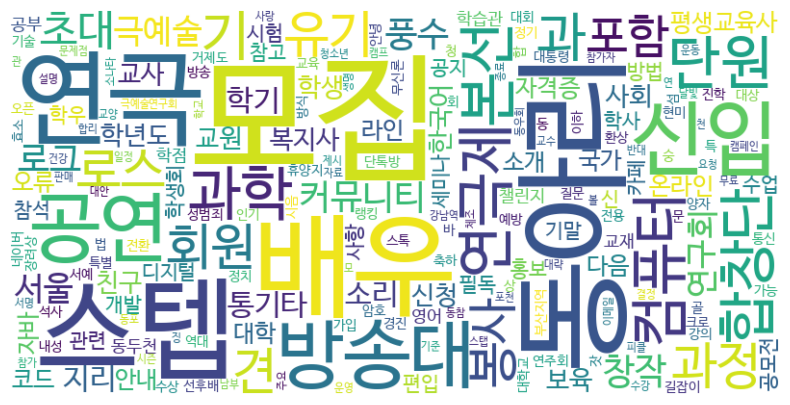

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## 단어 빈도를 바탕으로 워드클라우드 생성 및 표시
def plot_wordcloud(word_count):
    ## 워드 클라우드 생성
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)# word_count의 빈도 정보를 이용하여 생성

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear') ## 이미지 표시
    plt.axis("off") ## 축 비활성화
    plt.show() ## 그래프 표시

## cs_df에서 단어 빈도 계산
word_count = get_word_count(cs_df)
## 워드클라우드 생성 및 표시
plot_wordcloud(word_count)

## 13-11 다른 학과의 워드 클라우드 생성

<IPython.core.display.Javascript object>

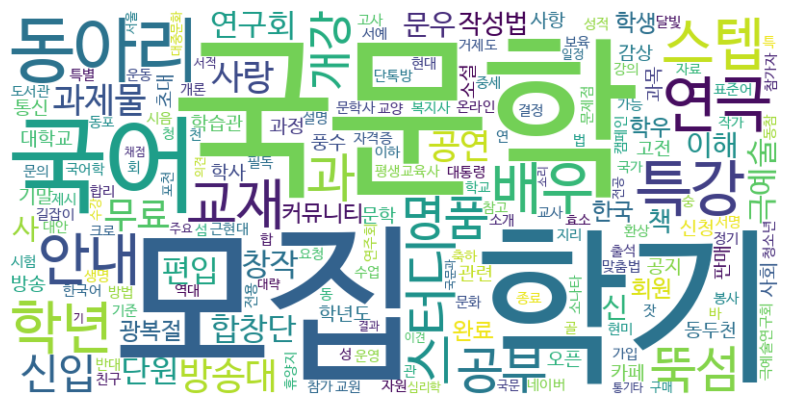

In [15]:
board_name = '국어국문학과'
board_url = 'https://korean.knou.ac.kr/korean/5323/subview.do'
board_titles = get_board_titles(url=board_url, pages=range(1,11), verbose=False)
ko_df = pd.DataFrame(data = {'제목': board_titles})
preprocessing_df(ko_df)
word_count = get_word_count(ko_df)
plot_wordcloud(word_count)

<IPython.core.display.Javascript object>

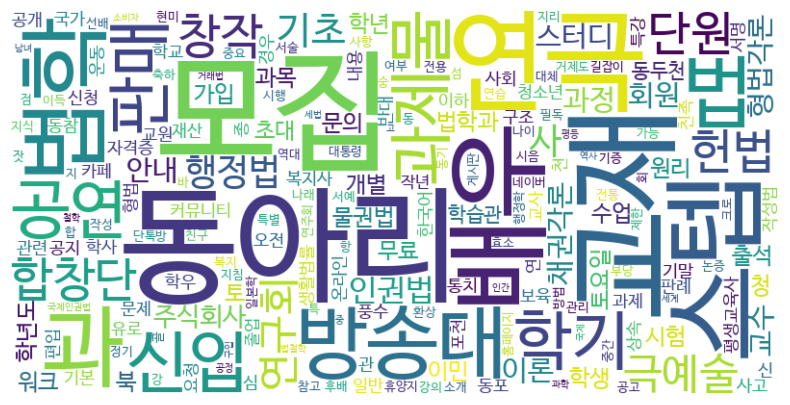

In [16]:
board_name = '법학과'
board_url = 'https://law.knou.ac.kr/law/5176/subview.do'
board_titles = get_board_titles(url=board_url, pages=range(1,11), verbose=False)
law_df = pd.DataFrame(data = {'제목': board_titles})
preprocessing_df(law_df)
word_count = get_word_count(law_df)
plot_wordcloud(word_count)

# 4. 텍스트 분류 및 시각화

## 13-12 VLLM 라이브러리 설치 및 LLM 모델 로드

주의
- 런타임 유형 : GPU
- 라이브러리 설치 및 모델 다운로드에 수 분(>6분)의 시간이 소요됩니다.


In [20]:
from vllm import LLM

## LLM 모델 로드 및 설정
llm = LLM(
    model="LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct",
    tensor_parallel_size=1,
    dtype="half",
    trust_remote_code=True,
    gpu_memory_utilization=0.6,
    max_model_len=32000
)

INFO 11-30 04:45:24 [utils.py:253] non-default args: {'trust_remote_code': True, 'dtype': 'half', 'max_model_len': 32000, 'gpu_memory_utilization': 0.6, 'disable_log_stats': True, 'model': 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


configuration_exaone.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct:
- configuration_exaone.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


INFO 11-30 04:45:48 [model.py:631] Resolved architecture: ExaoneForCausalLM
INFO 11-30 04:45:48 [model.py:1968] Downcasting torch.float32 to torch.float16.
INFO 11-30 04:45:48 [model.py:1745] Using max model len 32000
INFO 11-30 04:45:48 [scheduler.py:216] Chunked prefill is enabled with max_num_batched_tokens=8192.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

WARNING 11-30 04:45:52 [system_utils.py:103] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
INFO 11-30 04:50:55 [llm.py:352] Supported tasks: ['generate']


## 13-13 LLM 샘플링 파라미터 설정 및 프롬프트 생성

In [21]:
from vllm import SamplingParams ## SamplingParams 클래스 임포트

## 샘플링 파라미터 설정
sampling_params = SamplingParams(
    temperature=0.3, ## 생성 텍스트의 다양성 조절
    top_p=1.0, ## top_p 누적 확률 내에서 토큰 샘플링
    max_tokens=512, ## 생성될 최대 토큰 수
    frequency_penalty=0.5 ## 자주 나타나는 토큰에 대한 패널티
)

def format_prompt(user_input: str) -> str:
    ## 프롬프트 형식화 함수
    messages = [
        # 시스템 메시지 추가
        {"role": "system", "content": "You are EXAONE model from LG AI Research, a helpful assistant."},
        # 사용자 메시지 추가
        {"role": "user" , "content" : user_input}
    ]
    return messages

## 프롬프트 생성
prompt = format_prompt("대한민국의 수도는 어디인가요? 수도에 여행하러간다면 어떤 즐길거리가 있을까요?")

## LLM을 사용하여 텍스트 생성
# chat 함수를 이용 (프롬프트와 샘플링 파라미터)
outputs = llm.chat(prompt, sampling_params)

## 생성된 텍스트 출력
print("\n생성된 텍스트:", outputs[0].outputs[0].text)

INFO 11-30 04:55:19 [chat_utils.py:557] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


생성된 텍스트: 대한민국의 수도는 **서울**입니다. 서울은 역사적 유적지와 현대적인 문화 시설이 공존하는 매력적인 도시로, 다양한 여행 즐길거리를 제공합니다:

1. **역사 유적지**:
   - **경복궁**: 조선 시대의 궁궐로, 아름다운 정원과 전통 건축물을 감상할 수 있습니다.
   - **인사동**: 전통 공예품과 예술 작품을 구경하고 구매할 수 있는 곳입니다.
   - **북촌 한옥마을**: 전통 한옥들이 잘 보존되어 있어 한국의 옛 모습을 체험할 수 있습니다.

2. **현대 문화 및 엔터테인먼트**:
   - **롯데월드타워**: 서울의 랜드마크로, 전망대에서 서울 시내 전경을 감상하거나 다양한 테마파크를 즐길 수 있습니다.
   - **국립중앙박물관 및 국립현대미술관**: 세계적인 미술 작품과 한국의 역사 유물들을 관람할 수 있습니다.
   - **홍대 문화 거리**: 젊은 예술가들의 창작 활동이 활발한 지역으로, 음악 공연과 예술 전시회를 즐길 수 있습니다.

3. **쇼핑 및 미식**:
   - **명동 및 동대문 디자인 플라자(DDP)**: 쇼핑과 함께 현대적인 디자인 건축물도 감상할 수 있습니다.
   - **한강공원**: 한강변을 따라 걷거나 자전거 타며 자연을 즐기며, 저녁에는 야경 감상도 가능합니다. 특히 밤에는 한강변 카페나 레스토랑에서 특별한 경험을 할 수 있습니다.
   - **한식 맛집 탐방**: 다양한 한식 레스토랑에서 한국 전통 음식을 맛보며 현지 미식 문화를 체험해보세요. 특히 명동이나 강남 지역에 많은 맛집들이 모여 있습니다.

이러한 장소들은 서울 여행의 핵심 포인트로, 역사와 현대가 어우러진 매력적인 경험을 선사할 것입니다!


## 13-14 LLM 기반 분류 프롬프트 및 함수 정의

In [22]:
## 분류 프롬프트 형식화 함수
def format_classifier_prompt(board_title, title) -> str:
    messages = [
        {"role": "system", "content": "You are EXAONE model from LG AI Research, a helpful assistant."},
        {"role": "user", "content": """주어진 글의 제목을 분류하는 AI 모델입니다.
분류 클래스는 학사/전공, 학생활동, 외부정보로 나뉘어집니다.
- 학사/전공: 교재, 과제, 시험 등 학업 및 전공 관련 내용
- 학생활동: 동아리, 스터디, 모임 등 학생들의 자발적 활동
- 외부정보: 취업, 공모전, 행사 등 외부 정보"""},
        {"role": "user", "content": """예시)
전공명: 컴퓨터학과, 제목: 프로그래밍 과제 질문 -> 학사/전공
전공명: 컴퓨터학과, 제목: 알고리즘 스터디 모집 -> 학생활동
전공명: 컴퓨터학과, 제목: IT 취업 박람회 -> 외부정보"""},
        {"role": "user", "content": f"전공명: {board_title}\n제목: {title}"}
    ]
    return messages

## 분류 수행 함수
def classify(major, title):
    prompt = format_classifier_prompt(major, title) ## 분류 프롬프트 생성
    outputs = llm.chat([prompt], sampling_params) ## LLM으로 분류 실행
    return outputs[0].outputs[0].text ## 분류 결과 텍스트 반환

In [23]:
classify('컴퓨터학과', '딥러닝 개발 중에 질문 있습니다.')

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

'제목: "딥러닝 개발 중에 질문 있습니다."\n\n**분류:** 학생활동  \n**설명:** 이 제목은 딥러닝 관련 기술적인 질문을 공유하려는 맥락으로 보이며, 주로 개인적인 학습 과정이나 스터디 그룹 내에서의 토론과 관련이 있을 가능성이 높습니다. 따라서 **학생활동** 분류에 속합니다.'

In [24]:
classify('컴퓨터학과', '연극 동아리 회원 모집!! 신규 단원 혜택! AI로 배우는 연극!')

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

'**분류 결과:** 학생활동  \n**설명:** 제목이 "연극 동아리 회원 모집!! 신규 단원 혜택! AI로 배우는 연극!"로 주어져 있으며, 이는 학생들이 자발적으로 참여하는 동아리 활동과 관련된 내용을 담고 있습니다. 특히 "신규 단원 혜택"과 같은 문구는 학생들의 동아리 활동 참여를 유도하는 요소를 포함하고 있어 **학생활동** 분류에 해당합니다.'

## 13-15 분류 결과 파싱 함수 정의

In [25]:
def get_class(analysis_result):
    ## 분석 결과에서 분류 클래스 추출
    classes = ['학사/전공', '학생활동', '외부정보', '기타']
    classes_index = [analysis_result.find(cls) for cls in classes]

    min_index = float('inf')
    min_class = '기타'

    for i in range(len(classes)):
        current_index = classes_index[i]
        if current_index != -1 and current_index < min_index:
            min_index = current_index
            min_class = classes[i]

    return min_class

In [26]:
## 컴퓨터과학과 제목 분류 헬퍼 함수 정의
def classify_cs(title):
  return classify('컴퓨터과학과', title)

## '제목' 컬럼에 분류 함수 적용하여 분석 결과 저장
cs_df['class_analysis'] = cs_df['제목'].apply(classify_cs)
## 분석 결과에서 최종 분류 클래스 추출하여 저장
cs_df['class'] = cs_df['class_analysis'].apply(get_class)

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

## 13-17 분류 결과 시각화

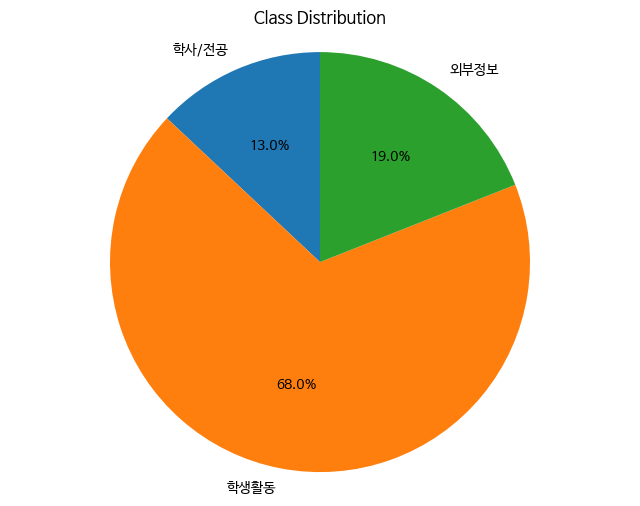

In [27]:
def plot_class(df):
  ## 분류 클래스별 개수 계산 및 순서 재정렬
  class_counts = df['class'].value_counts().reindex(['학사/전공', '학생활동', '외부정보'])

  plt.figure(figsize=(8, 6)) ## 그래프 크기 설정
  plt.pie(class_counts,
          labels=class_counts.index,
          autopct='%.1f%%', ## 퍼센트 표시 형식
          startangle=90, ## 시작 각도 설정
          )

  plt.title('Class Distribution') ## 그래프 제목 설정
  plt.axis('equal') ## 원형 비율 유지
  plt.show() ## 그래프 표시

plot_class(cs_df)

## 13-18 다른 학과의 분류 결과 시각화

In [ ]:
def classify_ko(title):
  return classify('국어국문학과', title)

ko_df['class_analysis'] = ko_df['제목'].apply(classify_ko)
ko_df['class'] = ko_df['class_analysis'].apply(get_class)

def classify_law(title):
  return classify('법학과', title)

law_df['class_analysis'] = law_df['제목'].apply(classify_law)
law_df['class'] = law_df['class_analysis'].apply(get_class)

In [ ]:
plot_class(ko_df)

In [ ]:
plot_class(law_df)